In [0]:
!pip install fastai2 -q

     |████████████████████████████████| 184kB 2.7MB/s 


In [0]:
from fastai2.tabular.all import *

In [0]:
!git clone https://github.com/pcsanwald/kaggle-titanic.git

fatal: destination path 'kaggle-titanic' already exists and is not an empty directory.


In [0]:
from fastai.basic_data import pathlib

In [0]:
path=pathlib.Path('kaggle-titanic')

In [0]:
path.ls()

(#9) [Path('kaggle-titanic/train.csv'),Path('kaggle-titanic/.git'),Path('kaggle-titanic/test'),Path('kaggle-titanic/src'),Path('kaggle-titanic/test.csv'),Path('kaggle-titanic/README.md'),Path('kaggle-titanic/project.clj'),Path('kaggle-titanic/.gitignore'),Path('kaggle-titanic/doc')]

In [0]:
df=pd.read_csv(path/'train.csv')
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
check=df.groupby(by='cabin')

In [0]:
#check.first()

In [0]:
cat_names=['pclass','name','sex','sibsp','parch','ticket','cabin','embarked']
cont_names=['age','fare']
y_name='survived'
procs=[Categorify, Normalize, FillMissing]

In [0]:
splits=RandomSplitter()(range_of(df))
splits

((#713) [733,16,195,472,527,644,2,233,854,299...],
 (#178) [595,79,150,886,134,260,90,36,377,148...])

In [0]:
to=TabularPandas(df,procs=procs, cat_names=cat_names, cont_names=cont_names, y_names=y_name, y_block=CategoryBlock(), splits=splits)

In [0]:
dls=to.dataloaders()

In [0]:
dls.show_batch()

,pclass,name,sex,sibsp,parch,ticket,cabin,embarked,age_na,age,fare,survived
0,1,"Barber, Miss. Ellen ""Nellie""",female,0,0,19877,#na#,S,False,26.000000,7.885000e+01,1
1,1,"McGough, Mr. James Robert",male,0,0,PC 17473,E25,S,False,36.000000,2.628750e+01,1
2,3,"Moubarek, Master. Halim Gonios (""William George"")",male,1,1,2661,#na#,C,True,28.000000,1.524580e+01,1
3,1,"Crosby, Capt. Edward Gifford",male,1,1,WE/P 5735,B22,S,False,70.000001,7.100000e+01,0
4,2,"Drew, Mrs. James Vivian (Lulu Thorne Christian)",female,1,1,28220,#na#,S,False,34.000000,3.250000e+01,1
5,3,"Maenpaa, Mr. Matti Alexanteri",male,0,0,STON/O 2. 3101275,#na#,S,False,22.000000,7.124999e+00,0
6,1,"Harper, Mr. Henry Sleeper",male,1,0,PC 17572,D33,C,False,48.000000,7.672920e+01,1
7,3,"Stoytcheff, Mr. Ilia",male,0,0,349205,#na#,S,False,19.000000,7.895800e+00,0
8,3,"Sirota, Mr. Maurice",male,0,0,392092,#na#,S,True,28.000000,8.050001e+00,0
9,3,"Leonard, Mr. Lionel",male,0,0,LINE,#na#,S,False,36.000000,4.644196e-07,0


In [0]:
config=tabular_config(ps=[0.1,0.1], embed_p=0.1)

In [0]:
learn=tabular_learner(dls, layers=[200,100], config=config, n_out=2, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.009120108559727669)

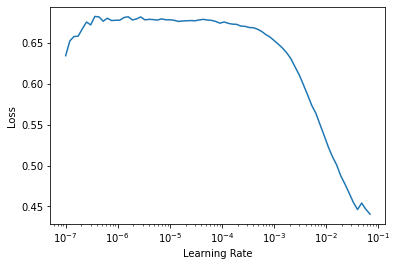

In [0]:
learn.lr_find()

In [0]:
learn.fit(5, lr=0.008)

epoch,train_loss,valid_loss,accuracy,time
0,0.568421,0.631872,0.679775,00:00
1,0.342186,0.652431,0.719101,00:00
2,0.205052,1.414538,0.707865,00:00
3,0.136664,1.318038,0.769663,00:00
4,0.097469,1.434821,0.814607,00:00


In [0]:
learn.save('stage1')

In [0]:
learn.load('stage1');

In [0]:
learn.unfreeze()

In [0]:
learn.fit(2,0.007)

epoch,train_loss,valid_loss,accuracy,time
0,0.059864,1.627834,0.792135,00:00
1,0.119770,0.873231,0.820225,00:00


In [0]:
learn.save('tradn')

In [0]:
learn.show_results()

,pclass,name,sex,sibsp,parch,ticket,cabin,embarked,age_na,age,fare,survived,survived_pred
0,3.0,0.0,2.0,1.0,1.0,0.0,0.0,3.0,1.0,-0.541206,-0.505841,0.0,0.0
1,3.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,-0.076586,-0.492734,1.0,1.0
2,3.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0,1.0,2.633697,-0.457151,1.0,0.0
3,3.0,0.0,2.0,1.0,1.0,0.0,0.0,3.0,1.0,-0.076586,-0.492389,0.0,0.0
4,1.0,0.0,1.0,1.0,3.0,2.0,0.0,3.0,1.0,-0.850953,1.002252,1.0,1.0
5,2.0,0.0,2.0,1.0,1.0,0.0,0.0,3.0,1.0,-0.154023,-0.386068,0.0,0.0
6,3.0,0.0,1.0,1.0,6.0,399.0,0.0,2.0,1.0,0.775217,-0.050184,0.0,0.0
7,1.0,0.0,1.0,1.0,1.0,0.0,78.0,3.0,1.0,1.549584,-0.116753,1.0,1.0
8,1.0,0.0,2.0,1.0,1.0,0.0,0.0,3.0,1.0,2.556260,-0.103822,0.0,0.0


In [0]:
del learn

**Bayesian optimization**

In [0]:
!pip install bayesian-optimization -q

In [0]:
from bayes_opt import BayesianOptimization

In [0]:
def fit_with( lr:float, ps1:float, ps2:float,wd:float,n_lay:float, lay1:float, lay2:float, lay3:float, embed:float, ep:float):
  print( lr,ps1,ps2,wd,embed,n_lay, lay1,lay2,lay3,ep)

  if int(n_lay) == 3:
    layers=[int(lay1), int(lay2), int(lay3)]
  elif int(n_lay) ==  2:
    layers=[int(lay1),int(lay2)]
  elif int(n_lay) == 1:
    layers=[int(lay1)]

  config=tabular_config(ps=[float(ps1),float(ps2)],embed_p=float(embed))
  learn=tabular_learner(dls, layers=layers, config=config, n_out=2, loss_func=CrossEntropyLossFlat(), metrics=accuracy, wd=float(wd))

  with learn.no_bar() and learn.no_logging():
    learn.fit(int(ep),lr= float(lr))

  acc=float(learn.validate()[1])

  return acc


In [0]:
hyp_p={ 
    
    'lr':(1e-05,1e-01),
    'wd':(4e-04,0.4),
    'ps1':(0.0001,0.1),
    'ps2':(0.0001,0.1),
    'n_lay':(1,3),
    'lay1':(50,200),
    'lay2':(100,500),
    'lay3':(200,500),
    'embed':(0.1,0.6),
    'ep':(1,15)
}

In [0]:
optim=BayesianOptimization(f=fit_with, pbounds=hyp_p, random_state=1)

In [0]:
%time optim.maximize(n_iter=15)

|   iter    |  target   |   embed   |    ep     |   lay1    |   lay2    |   lay3    |    lr     |   n_lay   |    ps1    |    ps2    |    wd     |
-------------------------------------------------------------------------------------------------------------------------------------------------
0.009242936090932092 0.03462151663160047 0.03973707067564393 0.21571116690774145 0.30851100235128703 1.3725204227553418 50.017156222601734 220.9330290527359 244.0267672451339 11.084542908190214


|  1        |  0.7247   |  0.3085   |  11.08    |  50.02    |  220.9    |  244.0    |  0.009243 |  1.373    |  0.03462  |  0.03974  |  0.2157   |
0.06705004634273844 0.0559131138617306 0.014124655165663854 0.07956135503831756 0.30959725720164744 1.834609604734254 80.66783745972762 451.2469745563782 208.21627795937786 10.593073005554633


|  2        |  0.7191   |  0.3096   |  10.59    |  80.67    |  451.2    |  208.2    |  0.06705  |  1.835    |  0.05591  |  0.01412  |  0.07956  |
0.0894617202837497 0.004001572844964948 0.017066058914500432 0.3513057443703935 0.5003722843377684 1.1700884227395558 97.01362672388643 376.92904626772565 462.9167456888115 14.555662060071565


|  3        |  0.7978   |  0.5004   |  14.56    |  97.01    |  376.9    |  462.9    |  0.08946  |  1.17     |  0.004002 |  0.01707  |  0.3513   |
0.03155840794429624 0.08347910462254755 0.0019269989066847614 0.300157668252009 0.14917341691652505 2.3730018553631673 193.6834295225753 313.2661139892068 407.563134185142 6.89550675007073


|  4        |  0.7528   |  0.1492   |  6.896    |  193.7    |  313.3    |  407.6    |  0.03156  |  2.373    |  0.08348  |  0.001927 |  0.3002   |
0.04479487368232876 0.029432053422530583 0.02884875632477624 0.052359417418463755 0.5944305444532474 2.8171910061861913 92.06659880966077 415.7117313805954 230.9678019732926 11.474319161317752


|  5        |  0.7584   |  0.5944   |  11.47    |  92.07    |  415.7    |  231.0    |  0.04479  |  2.817    |  0.02943  |  0.02885  |  0.05236  |
0.09999999909105632 0.0001 0.0001 0.00040000395403335325 0.6 3.0 200.0 500.0 500.0 15.0


|  6        |  0.7135   |  0.6      |  15.0     |  200.0    |  500.0    |  500.0    |  0.1      |  3.0      |  0.0001   |  0.0001   |  0.0004   |
0.0999999915722202 0.00010000462560731872 0.1 0.3999999928245878 0.1 2.999999996581254 50.0 100.0 500.0 15.0


|  7        |  0.7135   |  0.1      |  15.0     |  50.0     |  100.0    |  500.0    |  0.1      |  3.0      |  0.0001   |  0.1      |  0.4      |
0.0767031605971642 0.07944230209068695 0.05934015104177753 0.2153477993031 0.3756067980128748 1.8842441421611245 197.45757386271194 106.01703377045686 203.42246881164544 14.671531890704745


|  8        |  0.7865   |  0.3756   |  14.67    |  197.5    |  106.0    |  203.4    |  0.0767   |  1.884    |  0.07944  |  0.05934  |  0.2153   |
0.09348196637905769 0.0740779588372158 0.03438854961695225 0.030499257751756298 0.2345887681533073 1.1517043622443148 51.47952740903364 499.36276245157796 427.6744206512294 5.364157846886117


|  9        |  0.7921   |  0.2346   |  5.364    |  51.48    |  499.4    |  427.7    |  0.09348  |  1.152    |  0.07408  |  0.03439  |  0.0305   |
0.07122369081459143 0.0536557155072767 0.0015854825837136035 0.05041288223711006 0.46524763437386885 2.7317007079626556 199.28023718630726 332.2275642759363 201.53223863836442 9.716956859030741


|  10       |  0.7697   |  0.4652   |  9.717    |  199.3    |  332.2    |  201.5    |  0.07122  |  2.732    |  0.05366  |  0.001585 |  0.05041  |
0.0563141310744088 0.03855469952914752 0.07502110175487052 0.3984681248539962 0.20173375911507765 2.802555506138276 51.2633191575976 378.41402278718925 489.7871675729881 1.3323979999103022


|  11       |  0.5955   |  0.2017   |  1.332    |  51.26    |  378.4    |  489.8    |  0.05631  |  2.803    |  0.03855  |  0.07502  |  0.3985   |
0.09999996395673576 0.0001 0.1 0.4 0.6 1.0 200.0 500.0 300.322383528658 15.0


|  12       |  0.7416   |  0.6      |  15.0     |  200.0    |  500.0    |  300.3    |  0.1      |  1.0      |  0.0001   |  0.1      |  0.4      |
0.05752032439127647 0.0899368907611764 0.0730879577400677 0.10131183679270499 0.26242199230154994 1.4945271384422225 96.6539147380337 377.33718539827044 459.7894913675191 14.770119534448602


|  13       |  0.7584   |  0.2624   |  14.77    |  96.65    |  377.3    |  459.8    |  0.05752  |  1.495    |  0.08994  |  0.07309  |  0.1013   |
0.1 0.0001 0.0001 0.4 0.6 1.0 200.0 100.0 500.0 1.0


|  14       |  0.7472   |  0.6      |  1.0      |  200.0    |  100.0    |  500.0    |  0.1      |  1.0      |  0.0001   |  0.0001   |  0.4      |
0.1 0.0001 0.00010000280987501183 0.4 0.6 1.0 200.0 273.44573213049654 500.0 15.0


|  15       |  0.736    |  0.6      |  15.0     |  200.0    |  273.4    |  500.0    |  0.1      |  1.0      |  0.0001   |  0.0001   |  0.4      |
0.1 0.0001 0.0001 0.4 0.6 1.0 50.0 100.0 320.5350334289776 1.0


|  16       |  0.5955   |  0.6      |  1.0      |  50.0     |  100.0    |  320.5    |  0.1      |  1.0      |  0.0001   |  0.0001   |  0.4      |
0.1 0.0001 0.0001 0.4 0.6 3.0 50.0 100.0 200.0 1.0


|  17       |  0.7022   |  0.6      |  1.0      |  50.0     |  100.0    |  200.0    |  0.1      |  3.0      |  0.0001   |  0.0001   |  0.4      |
0.1 0.0001 0.0001 0.4 0.6 1.0 200.0 100.0 352.4796627947656 15.0


|  18       |  0.7921   |  0.6      |  15.0     |  200.0    |  100.0    |  352.5    |  0.1      |  1.0      |  0.0001   |  0.0001   |  0.4      |
0.07360810180898099 0.05143658953680155 0.02143323940210296 0.24262378821447733 0.4682812986574646 2.2042376699902086 182.71635006056937 404.7443525980986 499.2681530900761 2.5274836261553952


|  19       |  0.5955   |  0.4683   |  2.527    |  182.7    |  404.7    |  499.3    |  0.07361  |  2.204    |  0.05144  |  0.02143  |  0.2426   |
0.1 0.0001 0.0001 0.4 0.6 1.0 73.55315465294083 240.43406208890045 500.0 15.0


|  20       |  0.7809   |  0.6      |  15.0     |  73.55    |  240.4    |  500.0    |  0.1      |  1.0      |  0.0001   |  0.0001   |  0.4      |
CPU times: user 55 s, sys: 2.91 s, total: 57.9 s
Wall time: 57.1 s


In [0]:
print(optim.max)

{'target': 0.7977527976036072, 'params': {'embed': 0.5003722843377684, 'ep': 14.555662060071565, 'lay1': 97.01362672388643, 'lay2': 376.92904626772565, 'lay3': 462.9167456888115, 'lr': 0.0894617202837497, 'n_lay': 1.1700884227395558, 'ps1': 0.004001572844964948, 'ps2': 0.017066058914500432, 'wd': 0.3513057443703935}}


In [0]:
res=optim.max.get('params')
res

{'embed': 0.5003722843377684,
 'ep': 14.555662060071565,
 'lay1': 97.01362672388643,
 'lay2': 376.92904626772565,
 'lay3': 462.9167456888115,
 'lr': 0.0894617202837497,
 'n_lay': 1.1700884227395558,
 'ps1': 0.004001572844964948,
 'ps2': 0.017066058914500432,
 'wd': 0.3513057443703935}

In [0]:
config=tabular_config(ps=[0.004,0.01], embed_p=0.5)

In [0]:
learn=tabular_learner(dls, layers=[300,100], n_out=2, config=config, loss_func=CrossEntropyLossFlat(), metrics=accuracy, wd=0.35)

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.002511886414140463)

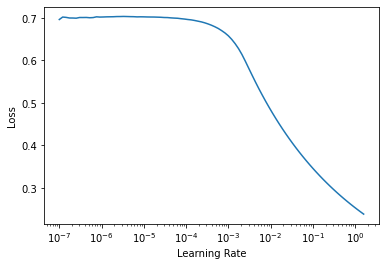

In [0]:
learn.lr_find()

In [0]:
learn.fit(14, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,2.577127,0.690612,0.595506,00:00
1,1.560297,0.723797,0.595506,00:00
2,1.176272,0.693695,0.415730,00:00
3,0.983264,0.698312,0.404494,00:00
4,0.857130,0.615230,0.752809,00:00
5,0.753392,0.536175,0.730337,00:00
6,0.665125,0.495995,0.792135,00:00
7,0.582070,1.019455,0.426966,00:00
8,0.523553,0.912261,0.769663,00:00
9,0.493388,0.586047,0.724719,00:00


In [0]:
learn.save('bhpt')

**XGBoost**

In [0]:
import xgboost as xgb

In [0]:
(x_train,y_train)=(to.train.xs, to.train.ys.values.ravel())
(x_valid,y_valid)=(to.valid.xs, to.valid.ys.values.ravel())


In [0]:
model=xgb.XGBClassifier(max_depth=8, learning_rate=0.01, subsample=0.5)

In [0]:
xgb_model=model.fit(x_train,y_train)

In [0]:
preds=fit.predict_proba(x_valid)

In [0]:
preds

array([[0.718635, 0.281365],
       [0.533874, 0.466126],
       [0.640807, 0.359193],
       [0.611549, 0.388451],
       ...,
       [0.279888, 0.720112],
       [0.477099, 0.522901],
       [0.388313, 0.611687],
       [0.678752, 0.321248]], dtype=float32)

In [0]:
accuracy(tensor(preds), tensor(y_valid))

tensor(0.8315)